In [ ]:
from google.colab import drive


In [ ]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


# Imports

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.linear_model import LinearRegression
#from spellchecker import SpellChecker # pyspellchecker

import re, os, math, sklearn, datetime, pickle

In [ ]:
movies_df = pd.read_pickle('/content/gdrive/MyDrive/raw_data/title_plot_movieId.pkl')

In [ ]:
ML_df = pd.read_csv('/content/gdrive/MyDrive/raw_data/MovieLens_20M/rating.csv')

In [ ]:
prompt_embeddings = np.load('/content/gdrive/MyDrive/raw_data/processed_data_shared/embedding_summary.npy')

In [ ]:
movie_embeddings = np.load('/content/gdrive/MyDrive/raw_data/processed_data_shared/embeddings_plot.npy')

In [ ]:
movies_embed = pd.DataFrame(movie_embeddings, index= movies_df['movieId'])

In [ ]:
prompts_embed = pd.DataFrame(prompt_embeddings, index= movies_df['movieId'])

In [ ]:
user_df = ML_df[['userId', 'movieId', 'rating']]

# Preprocessing

In [ ]:
user_df_fil = user_df[user_df['movieId'].isin(list(movies_df['movieId']))]

In [ ]:
rating_counts = user_df_fil.groupby('movieId').count()

In [ ]:
rating_counts_fil = rating_counts[rating_counts['rating']>=500].sort_values(by='rating')

In [ ]:
rating_counts_fil

,userId,rating
movieId,,
63479,500,500
74450,500,500
51471,501,501
59037,501,501
8800,501,501
...,...,...
589,52244,52244
110,53769,53769
480,59715,59715


In [ ]:
movies_keep = list(rating_counts_fil.index)

In [ ]:
len(movies_keep)

2449

In [ ]:
user_df_fil = user_df[user_df['movieId'].isin(movies_keep)]

In [ ]:
user_df_fil.shape

(11915796, 3)

In [ ]:
input_df = pd.DataFrame(columns =['promptId', 'movieId', 'rating'])
for m_id in movies_keep:
    movie_search = user_df_fil[user_df_fil['movieId'] == m_id]
    movie_search_users = movie_search[movie_search['rating'] >= 4]
    users = movie_search_users['userId']
    movie_search_ratings = user_df_fil[user_df_fil['userId'].isin(users)].groupby('movieId', as_index=False).agg({'rating': 'mean'})
    prompt_ids = pd.DataFrame(np.full((len(movie_search_ratings['movieId']),),m_id),columns=['promptId'])
    movie_search_input = pd.concat([prompt_ids,movie_search_ratings], axis=1)
    input_df = pd.concat([input_df,movie_search_input])


In [ ]:
input_df.shape

(5953368, 3)

In [ ]:
2449*2449

5997601

In [ ]:
y = input_df['rating']/5

In [ ]:
id_df = input_df[['promptId', 'movieId']]

In [ ]:
X_0 = pd.merge(left=id_df, right = movies_embed, how='left', left_on='promptId', right_index=True)

In [ ]:
X = pd.merge(left=X_0, right = movies_embed, how='left', left_on='movieId', right_index=True)

In [ ]:
X.shape

(5953368, 258)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.30, shuffle=True, random_state=42)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
y_test.shape

(1021105,)

In [ ]:
eval_df = X_test[['movieId']]

# Baseline model

In [ ]:
user_df_sc = user_df_fil.copy()
user_df_sc['rating'] = user_df_sc['rating']/5

In [ ]:
means_df = user_df_sc.groupby('movieId').agg({'rating': 'mean'})

In [ ]:
y_means = pd.merge(left=eval_df, right=means_df, left_on='movieId', right_index=True, how='left')

,movieId,rating
0,1,3.921240
1,2,3.211977
2,3,3.151040
3,4,2.861393
4,5,3.064592


In [ ]:
y_baseline = y_means['rating']

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
mean_squared_error(y_test, y_baseline)

0.004053428802720185

Model

In [ ]:
user_wants = keras.Input(shape= (128,))
movie_plot = keras.Input(shape= (128,))

## Liked genres Input:
user_liked = keras.layers.Dense(128, activation= 'relu')(user_wants)
liked_dropout_1 = keras.layers.Dropout(rate=0.2)(user_liked)
liked_hidden_1 = keras.layers.Dense(64, activation= 'relu')(liked_dropout_1)
liked_hidden_2 = keras.layers.Dense(32, activation= 'relu')(liked_hidden_1)
liked_hidden_3 = keras.layers.Dense(16, activation= 'relu')(liked_hidden_2)

## Movie Input:
movie_input = keras.layers.Dense(128, activation= 'relu')(movie_plot)
movie_dropout_1 = keras.layers.Dropout(rate=0.2)(movie_input)
movie_hidden_1 = keras.layers.Dense(64, activation= 'relu')(movie_dropout_1)
movie_hidden_2 = keras.layers.Dense(32, activation= 'relu')(movie_hidden_1)
movie_hidden_3 = keras.layers.Dense(16, activation= 'relu')(movie_hidden_2)

## Merging:
merged_model = keras.layers.concatenate([liked_hidden_2, movie_hidden_2])
merged_model_hidden_1 = keras.layers.Dense(32, activation= 'relu')(merged_model)
merged_dropout_1 = keras.layers.Dropout(rate=0.2)(merged_model_hidden_1)
merged_model_hidden_2 = keras.layers.Dense(16, activation= 'relu')(merged_dropout_1)
merged_model_hidden_3 = keras.layers.Dense(8, activation= 'relu')(merged_model_hidden_2)

## Output Layer:
output_rating = keras.layers.Dense(1, activation= 'linear')(merged_model_hidden_3)

## Molding the Model togther:
model_2 = keras.Model(inputs= [user_wants, movie_plot], outputs= output_rating)

## Compiling the Model:
model_2.compile(optimizer= keras.optimizers.Adam(learning_rate=0.001), loss= 'mean_squared_error')

In [ ]:
model_2.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 128)]                0         []                            
                                                                                                  
 dense_54 (Dense)            (None, 128)                  16512     ['input_13[0][0]']            
                                                                                                  
 dense_58 (Dense)            (None, 128)                  16512     ['input_14[0][0]']            
                                                                                            

In [ ]:
batch_size = 128
epochs = 40
es = EarlyStopping(patience=2, restore_best_weights=True)

history = model_2.fit(x= [X_train.iloc[:, 2:130], X_train.iloc[:, 130:]],
                  y= y_train,
                  epochs= epochs, verbose= 1, batch_size= batch_size, validation_split= 0.1, shuffle= True, callbacks = [es])

Epoch 1/40
29302/29302 [==============================] - 132s 4ms/step - loss: 0.0054 - val_loss: 0.0036
Epoch 2/40
29302/29302 [==============================] - 128s 4ms/step - loss: 0.0034 - val_loss: 0.0035
Epoch 3/40
29302/29302 [==============================] - 129s 4ms/step - loss: 0.0032 - val_loss: 0.0035
Epoch 4/40
29302/29302 [==============================] - 129s 4ms/step - loss: 0.0031 - val_loss: 0.0032
Epoch 5/40
29302/29302 [==============================] - 129s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 6/40
29302/29302 [==============================] - 129s 4ms/step - loss: 0.0030 - val_loss: 0.0032
Epoch 7/40
29302/29302 [==============================] - 131s 4ms/step - loss: 0.0029 - val_loss: 0.0032
Epoch 8/40
29302/29302 [==============================] - 129s 4ms/step - loss: 0.0029 - val_loss: 0.0033


# Evaluation

In [ ]:
model_2.evaluate([X_test.iloc[:, 2:130], X_test.iloc[:, 130:]], y_test)

55813/55813 [==============================] - 104s 2ms/step - loss: 0.0032


0.0031801946461200714

In [ ]:
8/40

0.2

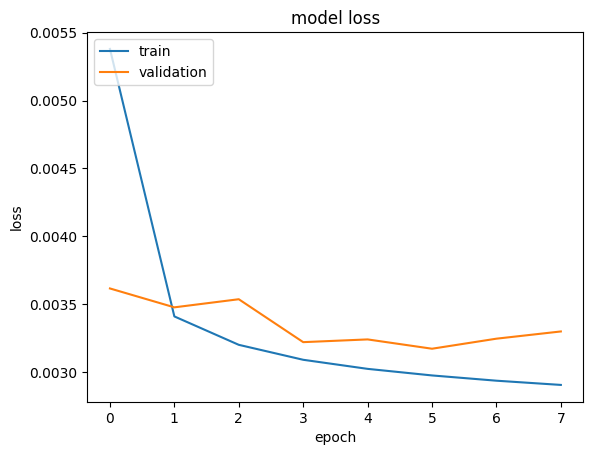

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
movies_embed.shape

(6204, 128)

In [ ]:
movies_embed_fil = movies_embed[movies_embed.index.isin(movies_keep)]

In [ ]:
movies_embed_fil.shape

(2449, 128)

In [ ]:
new_prompt = movies_embed_fil.head(1)

In [ ]:
new_prompts = pd.DataFrame(np.repeat(new_prompt.values, 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)

In [ ]:
new_data = pd.concat([new_prompts,movies_embed_fil],axis=1, join='outer')

In [ ]:
new_data.shape

(2449, 256)

In [ ]:
y_pred = model_2.predict([new_data.iloc[:, 0:128], new_data.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
ratings_pred = pd.DataFrame(y_pred, index = movies_embed_fil.index, columns=['ratings'])

In [ ]:
ratings_titles = pd.merge(left=ratings_pred, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)

In [ ]:
ratings_titles[0:20]

,movieId,ratings,title
48,1196,0.821670,Star Wars: Episode V - The Empire Strikes Back
532,908,0.818671,North by Northwest
82,5008,0.816089,Witness for the Prosecution
1575,4226,0.813389,Memento
249,1193,0.812274,One Flew Over the Cuckoo's Nest
49,750,0.812130,Dr. Strangelove or: How I Learned to Stop Worr...
81,3196,0.810436,Stalag 17
380,1203,0.809893,12 Angry Men
843,1204,0.809273,Lawrence of Arabia
1362,94466,0.809260,Black Mirror


In [ ]:
movies_embed_fil.head(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movieId,,,,,,,,,,,,,,,,,,,,,
62,-0.530416,0.078947,-4.174719,-1.435039,-0.898514,-0.367455,0.821316,2.128489,-0.941272,0.09233,...,-0.210147,-1.126048,0.432286,-0.112529,-0.043328,0.398397,-2.933069,0.120806,-0.261634,1.418717


In [ ]:
pd.merge(left=new_prompt, right=movies_df, left_index=True, right_on='movieId', how='left')

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,title,plot_synopsis,movieId
0,-0.530416,0.078947,-4.174719,-1.435039,-0.898514,-0.367455,0.821316,2.128489,-0.941272,0.09233,...,-0.112529,-0.043328,0.398397,-2.933069,0.120806,-0.261634,1.418717,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",62


In [ ]:
new_prompt_2 = movies_embed_fil.tail(1)

In [ ]:
movies_embed_fil.tail(1)

,0,1,2,3,4,5,6,7,8,9,...,118,119,120,121,122,123,124,125,126,127
movieId,,,,,,,,,,,,,,,,,,,,,
3728,-0.815098,-0.68295,-3.551226,-1.092486,0.052798,-1.020637,-0.344042,2.607695,-0.065807,0.684886,...,0.3909,-0.116829,-1.044274,-0.651202,-0.18648,1.035287,-1.555032,-0.338992,-1.114481,1.699152


In [ ]:
pd.merge(left=new_prompt_2, right=movies_df, left_index=True, right_on='movieId', how='left')

,0,1,2,3,4,5,6,7,8,9,...,121,122,123,124,125,126,127,title,plot_synopsis,movieId
7971,-0.815098,-0.68295,-3.551226,-1.092486,0.052798,-1.020637,-0.344042,2.607695,-0.065807,0.684886,...,-0.651202,-0.18648,1.035287,-1.555032,-0.338992,-1.114481,1.699152,One False Move,"Three criminals, Ray, Pluto and Fantasia (Ray'...",3728


In [ ]:
new_prompts_2 = pd.DataFrame(np.repeat(new_prompt_2.values, 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)
new_data_2 = pd.concat([new_prompts_2,movies_embed_fil],axis=1, join='outer')
y_pred_2 = model_2.predict([new_data_2.iloc[:, 0:128], new_data_2.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
y_pred_2

array([[0.72760844],
       [0.7731784 ],
       [0.7136944 ],
       ...,
       [0.6602894 ],
       [0.5566347 ],
       [0.6806607 ]], dtype=float32)

In [ ]:
ratings_pred_2 = pd.DataFrame(y_pred_2, index = movies_embed_fil.index, columns=['ratings'])
ratings_titles_2 = pd.merge(left=ratings_pred_2, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)



In [ ]:
ratings_titles_2[0:20]

,movieId,ratings,title
53,926,0.832605,All About Eve
1574,923,0.831149,Citizen Kane
314,1252,0.830635,Chinatown
49,750,0.830087,Dr. Strangelove or: How I Learned to Stop Worr...
1096,1178,0.824577,Paths of Glory
380,1203,0.822995,12 Angry Men
730,1213,0.820868,Goodfellas
82,5008,0.819879,Witness for the Prosecution
1121,1945,0.819574,On the Waterfront
532,908,0.819337,North by Northwest


In [ ]:
new_prompt_3 = movies_embed_fil.head(2)

In [ ]:
new_prompts_3 = pd.DataFrame(np.repeat([new_prompt_3.values[1]], 2449, axis=0), columns=[str(i) + "_" for i in range(0,128,1)], index = movies_embed_fil.index)
new_data_3 = pd.concat([new_prompts_3,movies_embed_fil],axis=1, join='outer')
y_pred_3 = model_2.predict([new_data_3.iloc[:, 0:128], new_data_3.iloc[:, 128:]])

77/77 [==============================] - 0s 2ms/step


In [ ]:
ratings_pred_3 = pd.DataFrame(y_pred_3, index = movies_embed_fil.index, columns=['ratings'])
ratings_titles_3 = pd.merge(left=ratings_pred_3, right = movies_df[['movieId','title']], on='movieId', how='left').sort_values(by='ratings', ascending=False)


In [ ]:
ratings_titles_3[0:20]

,movieId,ratings,title
49,750,0.830228,Dr. Strangelove or: How I Learned to Stop Worr...
1574,923,0.827645,Citizen Kane
314,1252,0.827458,Chinatown
53,926,0.826420,All About Eve
380,1203,0.822614,12 Angry Men
532,908,0.821920,North by Northwest
1096,1178,0.821073,Paths of Glory
48,1196,0.820670,Star Wars: Episode V - The Empire Strikes Back
82,5008,0.820512,Witness for the Prosecution
730,1213,0.818941,Goodfellas


In [ ]:
import pickle

In [ ]:
pickle.dump(model_2, open('/content/gdrive/MyDrive/model_2.pkl', 'wb'))

In [ ]:
pickle.dump(model, open('model_1.pkl', 'wb'))

In [ ]:
with open('/content/gdrive/MyDrive/model_1.pkl', 'wb') as files:
    pickle.dump(model, files)